# Test-Train and Predicting Weekly Tourism Arrivals
#### Now that we have the weekly tourism arrival data, we sum them up into each week in a year and test/train 2 models (Random Forest and Holt-Winters to see which gives us better accuracy and pick it to do a forecast for the proceeding 2 years. 

#### 1. Loading, cleaning and preparing the new dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load the data
file_path = r"C:\Users\brend\Downloads\Master_Doc_TestTrain.xlsx"  # <-- your path
df = pd.read_excel(file_path, sheet_name="maindata_1524")

def get_week_start(year, week):
    jan_1 = pd.Timestamp(year=int(year), month=1, day=1)
    week_start = jan_1 + pd.Timedelta(weeks=week-1)
    week_start = week_start - pd.Timedelta(days=week_start.weekday())
    return week_start
df['date'] = df.apply(lambda row: get_week_start(row['year'], row['week']), axis=1)
df_agg = df.groupby(['year', 'week']).agg({'weekly_arrivals': 'sum'}).reset_index()
df_agg['date'] = df_agg.apply(lambda row: get_week_start(row['year'], row['week']), axis=1)

#### 2. Random Forest and Holt-Winters Modelling

Training Random Forest model...
Training Holt-Winters model...


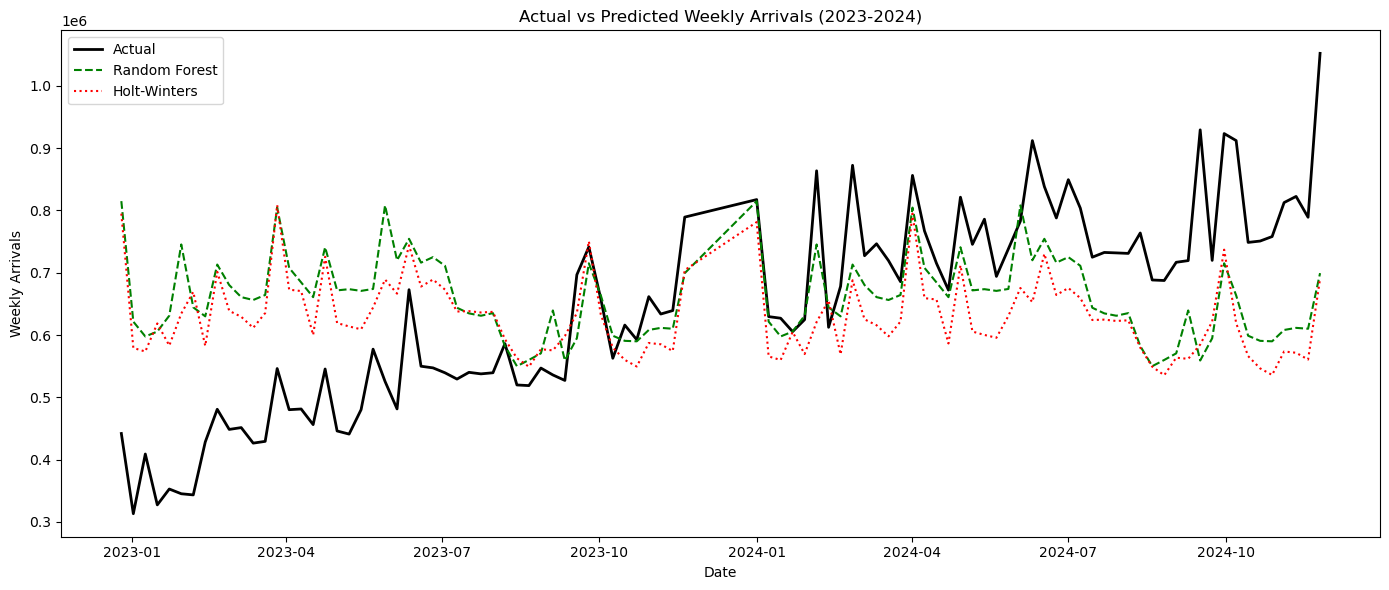

Model Comparison Results:


,Model,MAPE,MAE,RMSE
0,Random Forest,0.239879,131215.063316,163217.521442
1,Holt-Winters,0.241878,139751.579993,162283.302813


In [3]:
# Feature engineering for Random Forest
df_agg['sin_week'] = np.sin(2 * np.pi * df_agg['week'] / 48)
df_agg['cos_week'] = np.cos(2 * np.pi * df_agg['week'] / 48)
df_agg['year'] = df_agg['year'].astype(int)

# Split train/test
train_agg = df_agg[df_agg['year'].between(2015, 2019)].copy()
test_agg = df_agg[df_agg['year'].between(2023, 2024)].copy()

# Random Forest features and target
features = ['year', 'week', 'sin_week', 'cos_week']
X_train = train_agg[features]
y_train = train_agg['weekly_arrivals']
X_test = test_agg[features]
y_test = test_agg['weekly_arrivals']

# Train Random Forest
print('Training Random Forest model...')
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Holt-Winters
print('Training Holt-Winters model...')
hw_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=48).fit()
hw_pred = hw_model.forecast(steps=len(y_test))

# Metrics
def get_metrics(y_true, y_pred):
    return [
        mean_absolute_percentage_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred))
    ]
rf_metrics = get_metrics(y_test, rf_pred)
hw_metrics = get_metrics(y_test, hw_pred)

# Results table
results = pd.DataFrame({
    'Model': ['Random Forest', 'Holt-Winters'],
    'MAPE': [rf_metrics[0], hw_metrics[0]],
    'MAE': [rf_metrics[1], hw_metrics[1]],
    'RMSE': [rf_metrics[2], hw_metrics[2]]
})

# Plot
plt.figure(figsize=(14, 6))
plt.plot(test_agg['date'], y_test, label='Actual', color='black', linewidth=2)
plt.plot(test_agg['date'], rf_pred, label='Random Forest', linestyle='--', color='green')
plt.plot(test_agg['date'], hw_pred, label='Holt-Winters', linestyle=':', color='red')
plt.title('Actual vs Predicted Weekly Arrivals (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Weekly Arrivals')
plt.legend()
plt.tight_layout()
plt.show()

print('Model Comparison Results:')
results

#### 3. Using Random Forest to forecast 2025 and 2026

In [4]:
import pandas as pd
import numpy as np

# Create forecast features for 2025 and 2026 (48 weeks each)
forecast_data = []
for year in [2025, 2026]:
    for week in range(1, 49):
        forecast_data.append({
            'year': year,
            'week': week,
            'sin_week': np.sin(2 * np.pi * week / 48),
            'cos_week': np.cos(2 * np.pi * week / 48)
        })

forecast_df = pd.DataFrame(forecast_data)
X_forecast = forecast_df[['year', 'week', 'sin_week', 'cos_week']]

# Generate forecasts using Random Forest
rf_forecast = rf.predict(X_forecast)
forecast_df['predicted_arrivals'] = rf_forecast

# Add date column for reference
def get_week_start(year, week):
    jan_1 = pd.Timestamp(year=int(year), month=1, day=1)
    week_start = jan_1 + pd.Timedelta(weeks=week-1)
    week_start = week_start - pd.Timedelta(days=week_start.weekday())
    return week_start

forecast_df['date'] = forecast_df.apply(lambda row: get_week_start(row['year'], row['week']), axis=1)

# Split into separate dataframes for each year
forecast_2025 = forecast_df[forecast_df['year'] == 2025][['year', 'week', 'date', 'predicted_arrivals']].copy()
forecast_2026 = forecast_df[forecast_df['year'] == 2026][['year', 'week', 'date', 'predicted_arrivals']].copy()

# Export to Excel with separate sheets
with pd.ExcelWriter('japan_tourist_forecast_2025_2026.xlsx') as writer:
    forecast_2025.to_excel(writer, sheet_name='2025_forecast', index=False)
    forecast_2026.to_excel(writer, sheet_name='2026_forecast', index=False)

print('Forecast completed and exported to japan_tourist_forecast_2025_2026.xlsx')
print('2025 Forecast Summary:')
print(forecast_2025.head())
print('2026 Forecast Summary:')
print(forecast_2026.head())

Forecast completed and exported to japan_tourist_forecast_2025_2026.xlsx
2025 Forecast Summary:
   year  week       date  predicted_arrivals
0  2025     1 2024-12-30       814983.201903
1  2025     2 2025-01-06       621485.243906
2  2025     3 2025-01-13       597709.313429
3  2025     4 2025-01-20       605553.444649
4  2025     5 2025-01-27       631111.670320
2026 Forecast Summary:
    year  week       date  predicted_arrivals
48  2026     1 2025-12-29       814983.201903
49  2026     2 2026-01-05       621485.243906
50  2026     3 2026-01-12       597709.313429
51  2026     4 2026-01-19       605553.444649
52  2026     5 2026-01-26       631111.670320


#### 4. Visualizing the Forecast

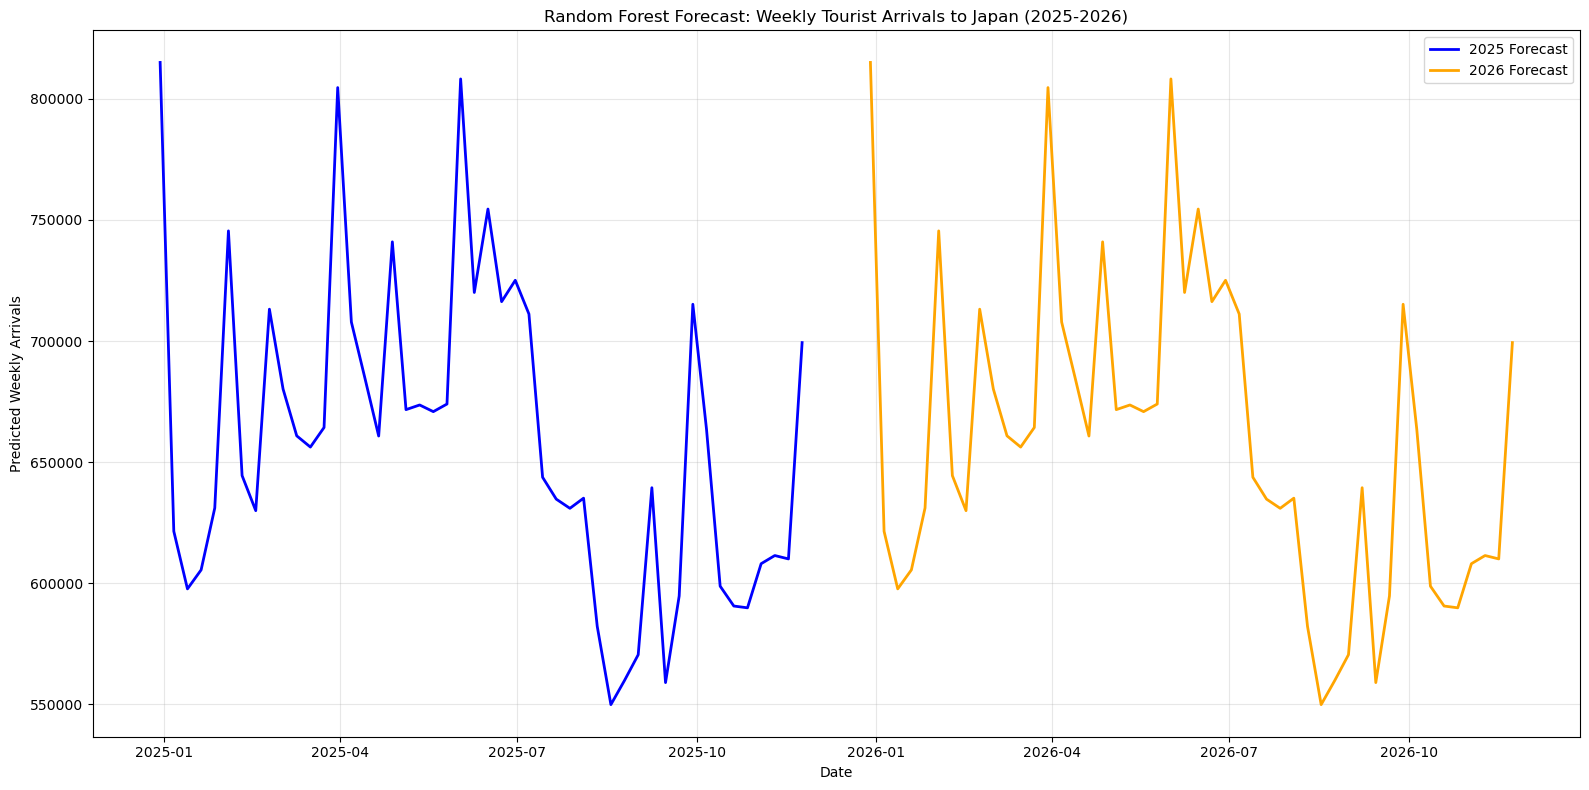

2025 Forecast Statistics:
Total arrivals: 31677495
Average weekly arrivals: 659947
Min weekly arrivals: 549952
Max weekly arrivals: 814983

2026 Forecast Statistics:
Total arrivals: 31677495
Average weekly arrivals: 659947
Min weekly arrivals: 549952
Max weekly arrivals: 814983


In [5]:
# Plot the forecast for both years
plt.figure(figsize=(16, 8))
plt.plot(forecast_2025['date'], forecast_2025['predicted_arrivals'], 
         label='2025 Forecast', color='blue', linewidth=2)
plt.plot(forecast_2026['date'], forecast_2026['predicted_arrivals'], 
         label='2026 Forecast', color='orange', linewidth=2)
plt.title('Random Forest Forecast: Weekly Tourist Arrivals to Japan (2025-2026)')
plt.xlabel('Date')
plt.ylabel('Predicted Weekly Arrivals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print('2025 Forecast Statistics:')
print('Total arrivals: ' + str(int(forecast_2025['predicted_arrivals'].sum())))
print('Average weekly arrivals: ' + str(int(forecast_2025['predicted_arrivals'].mean())))
print('Min weekly arrivals: ' + str(int(forecast_2025['predicted_arrivals'].min())))
print('Max weekly arrivals: ' + str(int(forecast_2025['predicted_arrivals'].max())))
print('')
print('2026 Forecast Statistics:')
print('Total arrivals: ' + str(int(forecast_2026['predicted_arrivals'].sum())))
print('Average weekly arrivals: ' + str(int(forecast_2026['predicted_arrivals'].mean())))
print('Min weekly arrivals: ' + str(int(forecast_2026['predicted_arrivals'].min())))
print('Max weekly arrivals: ' + str(int(forecast_2026['predicted_arrivals'].max())))